In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datacompy
import os, sys
import numpy as np
import re
import ast

# narzedzia
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    RepeatedStratifiedKFold,
    GridSearchCV,
)
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.spatial import distance
from joblib import dump, load

# modele
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# methods
from imblearn.under_sampling import ClusterCentroids, NearMiss
from scipy.optimize import differential_evolution
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier, NearestNeighbors
from sklearn.inspection import permutation_importance
from scipy.spatial.distance import euclidean
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
#from ctgan import CTGAN

In [24]:
#oversampling data
original_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\original_data.csv")    
original_data = original_data.drop(columns=["Unnamed: 0"])
smote_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\smote_data.csv")
GAN_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\GAN_data.csv")
borderline_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\borderline_data.csv")
smote2_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\smote3_data.csv")
GAN2_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\GAN3_data.csv")    
borderline2_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\borderline3_data.csv")

# test data
X_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\test\\X_test.csv")
y_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\test\\y_test.csv")

#Before undersampling
print(original_data["target"].value_counts())
count1=original_data["target"].value_counts().sum()
print(count1)
count2=abs((original_data['target']==0).sum() - (original_data['target']==1).sum())
print(f"Before undersampling: {count2}")
print(f"After number of samples: {count1+count2}")

target
0    151
1     46
Name: count, dtype: int64
197
Before undersampling: 105
After number of samples: 302


### Preprocessing Data

In [25]:
#mixed data
mix_data = pd.concat([GAN_data, smote_data, borderline_data, original_data], axis=0, ignore_index=True)         
mix_data = mix_data.reset_index(drop=True)

#data with one oversampling method and original data e.g.(smote+original)
smote_data = pd.concat([smote_data, smote2_data, original_data], axis=0, ignore_index=True)
smote_data = smote_data.reset_index(drop=True)
borderline_data = pd.concat([borderline_data, borderline2_data, original_data], axis=0, ignore_index=True)
borderline_data = borderline_data.reset_index(drop=True)
GAN_data = pd.concat([GAN_data, GAN2_data, original_data], axis=0, ignore_index=True)
GAN_data = GAN_data.reset_index(drop=True)

#convert data types to float64
int_cols = mix_data.select_dtypes(include=["int"]).columns
mix_data[int_cols] = mix_data[int_cols].astype("float64")
int_cols = smote_data.select_dtypes(include=["int"]).columns
smote_data[int_cols] = smote_data[int_cols].astype("float64")
int_cols = borderline_data.select_dtypes(include=["int"]).columns
borderline_data[int_cols] = borderline_data[int_cols].astype("float64")
int_cols = GAN_data.select_dtypes(include=["int"]).columns
GAN_data[int_cols] = GAN_data[int_cols].astype("float64")

sum_all_data = pd.concat([smote_data, GAN_data, borderline_data, original_data], axis=0, ignore_index=True)
sum_all_data = sum_all_data.drop_duplicates()


#Split data
X_mix, y_mix = mix_data.drop(columns=["target", "source"]), mix_data["target"]
X_smote, y_smote = smote_data.drop(columns=["target", "source"]), smote_data["target"]
X_GAN, y_GAN = GAN_data.drop(columns=["target", "source"]), GAN_data["target"]
X_borderline, y_borderline = borderline_data.drop(columns=["target", "source"]), borderline_data["target"]

#Dictionary
data = {}
data["mix"] = (X_mix, y_mix)
data["smote"] = (X_smote, y_smote)
data["GAN"] = (X_GAN, y_GAN)
data["borderline"] = (X_borderline, y_borderline)

compare = {}
compare["mix"] = mix_data
compare["smote"] = smote_data
compare["GAN"] = GAN_data
compare["borderline"] = borderline_data

### Undersampling

#### K-means + centroids

In [ ]:
KM = KMeans(n_clusters=(int)((count1+count2)/2))

for (name, (X_train, y_train)), (_, compare_df) in zip(data.items(), compare.items()):
    
    X_majority = X_train[y_train == 1]
    X_minority = X_train[y_train == 0]
    
    kmeans = KM.fit(X_majority)
    
    X_majority_reduced = pd.DataFrame(kmeans.cluster_centers_, columns=X_train.columns)
    y_majority_reduced = pd.Series([1] * (int)((count1+count2)/2), name="target") 
    
    X_minority = X_minority.reset_index(drop=True)
    y_minority = pd.Series([0] * len(X_minority), name="target")
    
    X_final = pd.concat([X_majority_reduced, X_minority], axis=0).reset_index(drop=True) 
    y_final = pd.concat([y_majority_reduced, y_minority], axis=0).reset_index(drop=True)
    
    # Concat resampled data
    reduced_data = pd.concat([X_final, y_final], axis=1)
    
    reduced_data["source"] = None  # Initialize the source column with None
    
    # gdy target = 1 wtedy source = "centroid", inaczej source = "original"
    
    # Compare data to copy source column
    data_nosource = compare_df
    reduced_data_nosource = reduced_data

    # Iterate through the rows in reduced_data_nosource
    for index, row in reduced_data_nosource.iterrows():
        match = data_nosource.eq(row).all(axis=1)  # Check where rows are identical
        if match.any():  # If a match is found
            matched_index = match.idxmax()  # Get the first matching index
            reduced_data.loc[index, "source"] = compare_df.loc[matched_index, "source"]
            
    # Check for any rows that still have None in the source column
    missing_source = reduced_data[reduced_data["source"].isna()]
    if not missing_source.empty:
        reduced_data.loc[reduced_data["source"].isna(), "source"] = "centroid"       
    
    reduced_data.to_csv(f"D:\\ml\\undersampling_data\\data\\ssh\\reduced\\{name}_KM_centroids_data.csv", index=False)
    
    print(f"Data reduced for {name} data")
    print(reduced_data["target"].value_counts())

#### K-means + the nearest neighbour

In [ ]:
#KM = KMeans(n_clusters=(int)((count1+count2)/2))

centroids_rows_ = {
    "mix": {},
    "smote": {},
    "GAN": {},
    "borderline": {}
}

centroids_ = {}

results_KM_SWAP_ = {
    "mix": {},
    "smote": {},
    "GAN": {},
    "borderline": {}
}

results_ = {}
df_ = {}

for (name, (X_train, y_train)), (_, compare_df) in zip(data.items(), compare.items()):
     # klasteryzacja dotyczy tylko jednego ze zbiorow drugi jest przepisywany
    X_majority = X_train[y_train == 1]
    X_minority = X_train[y_train == 0]
    
    kmeans = KM.fit(X_majority)
    
    #centroids
    for i in range ((int)((count1+count2)/2)):
        rows_in_cluster = X_majority[kmeans.labels_ == i] 
        centroids_rows_[name][i] = rows_in_cluster
        
        centroids_ = pd.DataFrame(kmeans.cluster_centers_, columns=X_train.columns)
    
    #results_KM_SWAP_ = {}
    
    
    for i in range(len(centroids_)):
        if (len(centroids_rows_[name][i])>1):
            dist_={}
            index_ = {}
            centroid = centroids_.iloc[i]
            for j in range(len(centroids_rows_[name][i])):
                index_ = list(centroids_rows_[name][i].index)
                row = centroids_rows_[name][i].iloc[j]
                index_map = {j: idx for j, idx in enumerate(index_)}
                dist_[j] = euclidean(centroid, row)         #tworze slwonik wartosci
                
            min_key = min(dist_, key=dist_.get)
            results_KM_SWAP_[name][i] = centroids_rows_[name][i].iloc[[min_key]]
            
        else:
            results_KM_SWAP_[name][i] = centroids_rows_[name][i].iloc[[0]]
        
        results_[name] = pd.concat(results_KM_SWAP_[name].values(), ignore_index=True)    
        
    df_y_majority = pd.Series([1] * (int)((count1+count2)/2), name="target") 
    df_majority = pd.concat([results_[name], df_y_majority], axis=1).reset_index(drop=True)
        
     
    df_X_minority = X_minority.reset_index(drop=True)
    df_y_minority = pd.Series([0] * len(X_minority), name="target")
    df_miniority = pd.concat([df_X_minority, df_y_minority], axis=1).reset_index(drop=True)

    df_[name] = pd.concat([df_majority, df_miniority], axis=0).reset_index(drop=True)  
    
    #copy source from sum_all_data 
    columns_ = list(df_[name].columns.values)
    df_[name] = df_[name].merge(sum_all_data, on=columns_, how="left")
    print(df_[name])  
    
    df_[name].to_csv(f"D:\\ml\\undersampling_data\\data\\ssh\\reduced\\{name}_KM_NN_data.csv", index=False)

#### K-means + cosinus

In [ ]:
#KM = KMeans(n_clusters=(int)((count1+count2)/2), init="k-means++")

centroids_rows_ = {
    "mix": {},
    "smote": {},
    "GAN": {},
    "borderline": {}
}

centroids_ = {}

results_KM_COS_ = {
    "mix": {},
    "smote": {},
    "GAN": {},
    "borderline": {}
}

results_ = {}
df_ = {}

for (name, (X_train, y_train)), (_, compare_df) in zip(data.items(), compare.items()):
     # klasteryzacja dotyczy tylko jednego ze zbiorow drugi jest przepisywany
    X_majority = X_train[y_train == 1]
    X_minority = X_train[y_train == 0]
    print(X_minority.shape)
    
    kmeans = KM.fit(X_majority)
    
    #centroids
    for i in range ((int)((count1+count2)/2)):
        rows_in_cluster = X_majority[kmeans.labels_ == i] 
        centroids_rows_[name][i] = rows_in_cluster
        
        centroids_ = pd.DataFrame(kmeans.cluster_centers_, columns=X_train.columns)
    
    #results_KM_COS_ = {}
    
    
    for i in range(len(centroids_)):                #dla kazdego z centroidow
        if (len(centroids_rows_[name][i])>1):       #sprawdzam czy jest wiecej niz jeden wiersz w klastrze
            dist_={}
            index_ = {}
            centroid = centroids_.iloc[i]
            centroid = centroid.values.reshape(1,-1)
            for j in range(len(centroids_rows_[name][i])):
                index_ = list(centroids_rows_[name][i].index)
                row = centroids_rows_[name][i].iloc[j]
                row = row.values.reshape(1,-1)
                index_map = {j: idx for j, idx in enumerate(index_)}
                dist_[j] = cosine_similarity(centroid, row)         #tworze slwonik wartosci
                
            min_key = min(dist_, key=dist_.get)
            results_KM_COS_[name][i] = centroids_rows_[name][i].iloc[[min_key]]
            
        else:
            results_KM_COS_[name][i] = centroids_rows_[name][i].iloc[[0]]
        
        results_[name] = pd.concat(results_KM_COS_[name].values(), ignore_index=True)    
        
    df_y_majority = pd.Series([1] * (int)((count1+count2)/2), name="target") 
    df_majority = pd.concat([results_[name], df_y_majority], axis=1).reset_index(drop=True)
    print(df_majority.shape)  
     
    df_X_minority = X_minority.reset_index(drop=True)
    df_y_minority = pd.Series([0] * len(X_minority), name="target")
    df_miniority = pd.concat([df_X_minority, df_y_minority], axis=1).reset_index(drop=True)
    print(df_miniority.shape)

    df_[name] = pd.concat([df_majority, df_miniority], axis=0).reset_index(drop=True)  
    print(df_[name])
    
    #copy source from sum_all_data 
    columns_ = list(df_[name].columns.values)
    df_[name] = df_[name].merge(sum_all_data, on=columns_, how="left")
    print(df_[name])  
    print(df_[name].dtypes)
    
    df_[name].to_csv(f"D:\\ml\\undersampling_data\\data\\ssh\\reduced\\{name}_KM_COS_data.csv", index=False)
    
    print(f"Num duplicates: {df_[name].duplicated().sum()}")
    

#### K-means + cosinus + Mahalanobis distance (reduced to linear form, as it allows a simpler comparison)

In [ ]:
#KM = KMeans(n_clusters=(int)((count1+count2)/2), init="k-means++")

centroids_rows_ = {
    "mix": {},
    "smote": {},
    "GAN": {},
    "borderline": {}
}

centroids_ = {}

results_KM_COS_ = {
    "mix": {},
    "smote": {},
    "GAN": {},
    "borderline": {}
}

results_ = {}
df_ = {}

alfa = 0.5 # weight for cosine similarity and Mahalanobis distance

for (name, (X_train, y_train)), (_, compare_df) in zip(data.items(), compare.items()):
     # klasteryzacja dotyczy tylko jednego ze zbiorow drugi jest przepisywany
    X_majority = X_train[y_train == 1]
    X_minority = X_train[y_train == 0]
    print(X_minority.shape)
    
    kmeans = KM.fit(X_majority)
    
    #centroids
    for i in range ((int)((count1+count2)/2)):
        rows_in_cluster = X_majority[kmeans.labels_ == i] 
        centroids_rows_[name][i] = rows_in_cluster
        
        centroids_ = pd.DataFrame(kmeans.cluster_centers_, columns=X_train.columns)
    
    #results_KM_COS_ = {}
    
    
    for i in range(len(centroids_)):                #dla kazdego z centroidow
        if (len(centroids_rows_[name][i])>1):       #sprawdzam czy jest wiecej niz jeden wiersz w klastrze
            cos_={}
            dist_={}
            comb_score_ = {} # results for cosine similarity and Mahalanobis distance
            index_ = {}
            centroid = centroids_.iloc[i]
            centroid = centroid.values.reshape(1,-1)
            for j in range(len(centroids_rows_[name][i])):
                index_ = list(centroids_rows_[name][i].index)
                row = centroids_rows_[name][i].iloc[j]
                row = row.values.reshape(1,-1)
                index_map = {j: idx for j, idx in enumerate(index_)}
                cos_[j] = cosine_similarity(centroid, row)         #tworze slwonik wartosci
                dist_[j] = distance.mahalanobis(centroid, row, np.linalg.inv(np.cov(X_train.T)))  #using Mahalanobis distance
                
                comb_score_[j] = (alfa*cos_[j] + (1-alfa)*dist_[j])
                
            min_key = min(comb_score_, key=comb_score_.get)
            results_KM_COS_[name][i] = centroids_rows_[name][i].iloc[[min_key]]
            
        else:
            results_KM_COS_[name][i] = centroids_rows_[name][i].iloc[[0]]
        
        results_[name] = pd.concat(results_KM_COS_[name].values(), ignore_index=True)    
        
    df_y_majority = pd.Series([1] * (int)((count1+count2)/2), name="target") 
    df_majority = pd.concat([results_[name], df_y_majority], axis=1).reset_index(drop=True)
    print(df_majority.shape)  
     
    df_X_minority = X_minority.reset_index(drop=True)
    df_y_minority = pd.Series([0] * len(X_minority), name="target")
    df_miniority = pd.concat([df_X_minority, df_y_minority], axis=1).reset_index(drop=True)
    print(df_miniority.shape)

    df_[name] = pd.concat([df_majority, df_miniority], axis=0).reset_index(drop=True)  
    print(df_[name])
    
    #copy source from sum_all_data 
    columns_ = list(df_[name].columns.values)
    df_[name] = df_[name].merge(sum_all_data, on=columns_, how="left")
    print(df_[name])  
    print(df_[name].dtypes)
    
    df_[name].to_csv(f"D:\\ml\\undersampling_data\\data\\ssh\\reduced\\{name}_KM_COS_data.csv", index=False)
    
    print(f"Num duplicates: {df_[name].duplicated().sum()}")
    

#### DBSCAN + distance

In [26]:
#standard scaler
scaler = StandardScaler()
#columns to scale
columns = mix_data.columns.difference(["user", "target", "source", "is_private", "is_failure", "is_valid", "is_root", "first"])
#copy data to scale
mix_data_scaled = mix_data.copy()
smote_data_scaled = smote_data.copy()
GAN_data_scaled = GAN_data.copy()
borderline_data_scaled = borderline_data.copy()
#rescale data
mix_data_scaled[columns] = scaler.fit_transform(mix_data[columns])
smote_data_scaled[columns] = scaler.fit_transform(smote_data[columns])
GAN_data_scaled[columns] = scaler.fit_transform(GAN_data[columns])
borderline_data_scaled[columns] = scaler.fit_transform(borderline_data[columns])

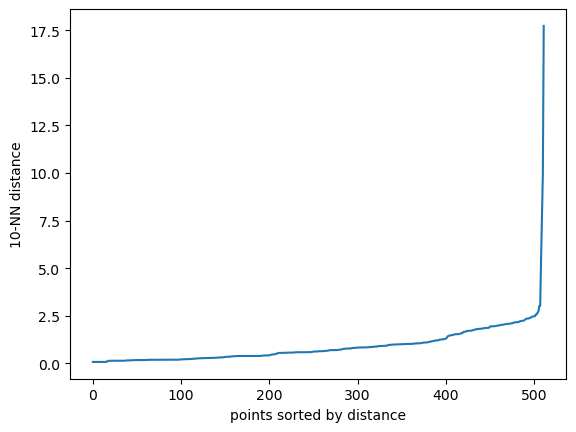

In [33]:
dbscan = DBSCAN(eps=2, min_samples=10)
k=10
nn = NearestNeighbors(n_neighbors=k)
X_mix_data_scaled = mix_data_scaled.drop(columns=["target", "source", "user"])
nn.fit(X_mix_data_scaled)
distances, _ = nn.kneighbors(X_mix_data_scaled)
k_dist = np.sort(distances[:, -1])
plt.plot(k_dist)
plt.ylabel(f"{k}-NN distance")
plt.xlabel("points sorted by distance")
plt.show()

In [ ]:
dbscan = DBSCAN(eps=2.5, min_samples=5)

for (name, (X_train, y_train)), (_, compare_df) in zip(data.items(), compare.items()):
     # klasteryzacja dotyczy tylko jednego ze zbiorow drugi jest przepisywany
    X_majority = X_train[y_train == 1]
    X_minority = X_train[y_train == 0]
    print(X_majority)
    print(X_minority.shape)
    print(name)
    
    dbscan_res = dbscan.fit(X_majority)
    print(dbscan_res.labels_)

     user  is_private  is_failure  is_root  is_valid  not_valid_count  \
0     9.0         0.0         1.0      0.0       1.0              3.0   
1    45.0         1.0         1.0      1.0       0.0             12.0   
2    40.0         0.0         1.0      1.0       1.0             15.0   
3     8.0         1.0         1.0      1.0       1.0              7.0   
4     7.0         0.0         1.0      0.0       0.0              1.0   
..    ...         ...         ...      ...       ...              ...   
471  40.0         1.0         1.0      0.0       1.0              0.0   
473  37.0         1.0         1.0      1.0       1.0              0.0   
489  27.0         1.0         1.0      0.0       0.0              9.0   
491  41.0         1.0         1.0      0.0       0.0              7.0   
495  30.0         1.0         1.0      1.0       1.0              0.0   

     ip_failure  ip_success  no_failure  first     td        ts  
0          34.0         0.0        15.0    0.0   13.0 -0.

#### DBSCAN + cosinus

#### K-means (resampling = calculate by DBSCAN) + centroids

#### K-means (resampling = calculate by DBSCAN) + the nearest neighbour

#### K-means (resampling = calculate by DBSCAN) + cosinus

#### K-means (resampling = calculate by DBSCAN) + cosinus + distance